# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [59]:
# !pip install gensim
# !pip install nltk
# !pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [9]:
# !wget -O Train_rev1.zip https://yadi.sk/d/vVEOWPFY3NruT7
# !unzip Train_rev1

In [4]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
3849,59920957,Customer Relations/ Membership Sales Manager –...,We are looking for a person to support the Gen...,South Norwood,Norwood,NaN,permanent,Fusion,Travel Jobs,"Up to 18,500 per annum",18500,leisurejobs.com,9.825580
156622,71096973,Registered General Nurse (RGN; RN) York,Registered General Nurse (RGN; RN) needed for ...,York,York,part_time,NaN,The A24 Group,Healthcare & Nursing Jobs,20.09 - 27.00/Hour,45206,staffnurse.com,10.719007
29839,68058322,CHOKE VALVE SALES ENGINEER,CHOKE VALVE SALES ENGINEER YOU MUST HAVE PREVI...,West Yorkshire Yorkshire,West Yorkshire,NaN,permanent,Code Blue Recruitment,Sales Jobs,"From 28,000 to 31,000 per annum",29500,totaljobs.com,10.292179


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [5]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [6]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [7]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [8]:
from collections import Counter
token_counts = Counter()

for line in range(len(data)):
    token_counts.update(data['Title'][line].split())
    token_counts.update(data['FullDescription'][line].split())

In [9]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

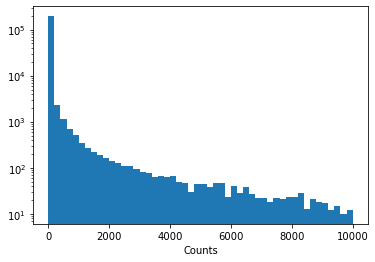

In [10]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [11]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token in token_counts if token_counts[token] >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [12]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [13]:
token_to_id = {token: tokens.index(token) for token in tokens}

In [14]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [15]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [58]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  550  2380     1     1     1]
 [  320 10714   392   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [17]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [18]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [19]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [20]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[ 2501,   266,     1,     1,     1,     1],
        [  421,    23,   901,  1783,   654,   655],
        [ 1526,  2380, 16440,  4723,     1,     1]], dtype=int32),
 'FullDescription': array([[  230,    66,    19,   420,  2501,  3722,    43,   448,    47,
            56],
        [   49,   421,    23,   901,    14,   433,   103,   129,   224,
           226],
        [ 1526,  2380, 16440,  4723,     8,   410,     7,  2225,    65,
           103]], dtype=int32),
 'Categorical': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([10.477316, 10.71444 ,  9.615872], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [21]:
import torch, torch.nn as nn
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [22]:
device = torch.device('cuda:{}'.format(torch.cuda.current_device())) if torch.cuda.is_available() else 'cpu'
device

device(type='cuda', index=0)

In [23]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu(h)
        h = self.dense(h)
        
        return h

In [24]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = torch.LongTensor(generate_batch(data_train, 3)['Title'])
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [25]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu(h)
        h = self.dense(h)

        return h

In [26]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = torch.LongTensor(generate_batch(data_train, 3)['FullDescription'])
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [27]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(n_tokens, out_size=64)
        self.desc_encoder = DescriptionEncoder(n_tokens, out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense1 = nn.Linear(n_cat_features, 100)
        self.dense2 = nn.Linear(100, 64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense_final = nn.Linear(192, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense2(self.dense1(cat_features))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top

        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return self.dense_final(joint_h)[:, 0]

In [28]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [29]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.LongTensor(batch["Title"]).to(device)
desc_ix = torch.LongTensor(batch["FullDescription"]).to(device)
cat_features = torch.FloatTensor(batch["Categorical"]).to(device)
reference = torch.FloatTensor(batch[target_column]).to(device)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [30]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [31]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [32]:
from tqdm import trange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = trange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [33]:
import time

def train(model, opt, batch_size, patience=5, num_epochs=10, model_name='model1', batches_per_epoch = 100, save=False):
    train_loss_ar = []
    val_loss_ar = []

    trigger_times = 0
    train_loss = train_mae = train_batches = 0  
    val_loss = val_mae = val_batches = 0

    prev_val = -np.Inf
    val_min = +np.Inf

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train(True)
        for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
            title_ix = torch.LongTensor(batch["Title"]).to(device, non_blocking=True)
            desc_ix = torch.LongTensor(batch["FullDescription"]).to(device, non_blocking=True)
            cat_features = torch.FloatTensor(batch["Categorical"]).to(device, non_blocking=True)
            reference = torch.FloatTensor(batch[target_column]).to(device, non_blocking=True)

            prediction = model(title_ix, desc_ix, cat_features)

            loss = compute_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad(set_to_none=True)

            train_loss += loss.data.cpu().numpy()
            train_mae += compute_mae(reference, prediction).data.cpu().numpy()
            train_batches += 1
            
            train_loss_ar.append(loss.item())
            
        with torch.no_grad():
            model.train(False)
            for batch in iterate_minibatches(data_val, shuffle=False):
                title_ix = torch.LongTensor(batch["Title"]).to(device, non_blocking=True)
                desc_ix = torch.LongTensor(batch["FullDescription"]).to(device, non_blocking=True)
                cat_features = torch.FloatTensor(batch["Categorical"]).to(device, non_blocking=True)
                reference = torch.FloatTensor(batch[target_column]).to(device, non_blocking=True)

                prediction = model(title_ix, desc_ix, cat_features)
                loss = compute_loss(reference, prediction)

                val_loss += loss.data.cpu().numpy()
                val_mae += compute_mae(reference, prediction).data.cpu().numpy()
                val_batches += 1
                
                val_loss_ar.append(loss.item())
                
            val_mean = np.mean(val_loss_ar[-batches_per_epoch * num_epochs // batch_size:])


        if val_mean < val_min and save:
            torch.save({
                'epoch': epoch,
                'val_mean': val_mean,
                'state_dict': model.state_dict(),
                'optimizer': opt.state_dict(),
            }, 'models/' + model_name + f'_{epoch+1}.pth')

            val_min = val_mean

        if val_mean > prev_val:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping\n')
                break
        else:
            trigger_times = 0

        prev_val = val_mean

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss_ar[-batches_per_epoch * num_epochs // batch_size:])))
        print("  validation loss: \t\t\t{:.3f}".format(
            val_mean))

In [34]:
num_epochs = 100
batch_size = 32

train(model, opt, batch_size=batch_size, patience=5, num_epochs=num_epochs, model_name='model1', batches_per_epoch = 100, save=True)

100%|██████████| 765/765 [00:07<00:00, 108.80it/s]


Epoch 1 of 100 took 9.008s
  training loss (in-iteration): 	8.725797
  validation loss: 			62.423


100%|██████████| 765/765 [00:07<00:00, 103.93it/s]


Epoch 2 of 100 took 9.303s
  training loss (in-iteration): 	4.607686
  validation loss: 			41.105


100%|██████████| 765/765 [00:07<00:00, 102.51it/s]


Epoch 3 of 100 took 9.339s
  training loss (in-iteration): 	3.194679
  validation loss: 			32.390


100%|██████████| 765/765 [00:07<00:00, 104.00it/s]


Epoch 4 of 100 took 9.247s
  training loss (in-iteration): 	0.401203
  validation loss: 			28.031


100%|██████████| 765/765 [00:07<00:00, 103.72it/s]


Epoch 5 of 100 took 9.309s
  training loss (in-iteration): 	0.318960
  validation loss: 			25.051


100%|██████████| 765/765 [00:07<00:00, 104.70it/s]


Epoch 6 of 100 took 9.210s
  training loss (in-iteration): 	0.272481
  validation loss: 			23.455


100%|██████████| 765/765 [00:07<00:00, 103.41it/s]


Epoch 7 of 100 took 9.302s
  training loss (in-iteration): 	0.237620
  validation loss: 			21.692


100%|██████████| 765/765 [00:07<00:00, 103.16it/s]


Epoch 8 of 100 took 9.367s
  training loss (in-iteration): 	0.221719
  validation loss: 			21.042


100%|██████████| 765/765 [00:07<00:00, 103.95it/s]


Epoch 9 of 100 took 9.286s
  training loss (in-iteration): 	0.211306
  validation loss: 			20.867


100%|██████████| 765/765 [00:07<00:00, 103.52it/s]


Epoch 10 of 100 took 9.345s
  training loss (in-iteration): 	0.205305
  validation loss: 			19.903


100%|██████████| 765/765 [00:07<00:00, 103.33it/s]


Epoch 11 of 100 took 9.319s
  training loss (in-iteration): 	0.192581
  validation loss: 			18.126


100%|██████████| 765/765 [00:07<00:00, 102.75it/s]


Epoch 12 of 100 took 9.409s
  training loss (in-iteration): 	0.185202
  validation loss: 			17.107


100%|██████████| 765/765 [00:07<00:00, 102.37it/s]


Epoch 13 of 100 took 9.340s
  training loss (in-iteration): 	0.178517
  validation loss: 			17.604


100%|██████████| 765/765 [00:07<00:00, 103.08it/s]


Epoch 14 of 100 took 9.236s
  training loss (in-iteration): 	0.174709
  validation loss: 			17.627


100%|██████████| 765/765 [00:07<00:00, 102.17it/s]


Epoch 15 of 100 took 9.376s
  training loss (in-iteration): 	0.168282
  validation loss: 			18.977


100%|██████████| 765/765 [00:07<00:00, 101.23it/s]


Epoch 16 of 100 took 9.478s
  training loss (in-iteration): 	0.163430
  validation loss: 			14.589


100%|██████████| 765/765 [00:07<00:00, 102.58it/s]


Epoch 17 of 100 took 9.299s
  training loss (in-iteration): 	0.153806
  validation loss: 			16.480


100%|██████████| 765/765 [00:07<00:00, 102.12it/s]


Epoch 18 of 100 took 9.435s
  training loss (in-iteration): 	0.148035
  validation loss: 			14.421


100%|██████████| 765/765 [00:07<00:00, 104.33it/s]


Epoch 19 of 100 took 9.177s
  training loss (in-iteration): 	0.144598
  validation loss: 			15.182


100%|██████████| 765/765 [00:07<00:00, 103.84it/s]


Epoch 20 of 100 took 9.257s
  training loss (in-iteration): 	0.143483
  validation loss: 			15.701


100%|██████████| 765/765 [00:07<00:00, 103.27it/s]


Epoch 21 of 100 took 9.327s
  training loss (in-iteration): 	0.141206
  validation loss: 			14.065


100%|██████████| 765/765 [00:07<00:00, 103.54it/s]


Epoch 22 of 100 took 9.256s
  training loss (in-iteration): 	0.135939
  validation loss: 			15.051


100%|██████████| 765/765 [00:07<00:00, 100.83it/s]


Epoch 23 of 100 took 9.526s
  training loss (in-iteration): 	0.132449
  validation loss: 			12.829


100%|██████████| 765/765 [00:07<00:00, 103.13it/s]


Epoch 24 of 100 took 9.290s
  training loss (in-iteration): 	0.127041
  validation loss: 			15.875


100%|██████████| 765/765 [00:07<00:00, 101.87it/s]


Epoch 25 of 100 took 9.362s
  training loss (in-iteration): 	0.126487
  validation loss: 			13.318


100%|██████████| 765/765 [00:07<00:00, 102.76it/s]


Epoch 26 of 100 took 9.294s
  training loss (in-iteration): 	0.129504
  validation loss: 			20.379


100%|██████████| 765/765 [00:07<00:00, 102.53it/s]


Epoch 27 of 100 took 9.310s
  training loss (in-iteration): 	0.130117
  validation loss: 			13.860


100%|██████████| 765/765 [00:07<00:00, 103.82it/s]


Epoch 28 of 100 took 9.297s
  training loss (in-iteration): 	0.126214
  validation loss: 			11.950


100%|██████████| 765/765 [00:07<00:00, 103.61it/s]


Epoch 29 of 100 took 9.332s
  training loss (in-iteration): 	0.119195
  validation loss: 			11.672


100%|██████████| 765/765 [00:07<00:00, 101.59it/s]


Epoch 30 of 100 took 9.378s
  training loss (in-iteration): 	0.116090
  validation loss: 			12.008


100%|██████████| 765/765 [00:07<00:00, 103.85it/s]


Epoch 31 of 100 took 9.228s
  training loss (in-iteration): 	0.118399
  validation loss: 			11.897


100%|██████████| 765/765 [00:07<00:00, 102.48it/s]


Epoch 32 of 100 took 9.380s
  training loss (in-iteration): 	0.118906
  validation loss: 			11.515


100%|██████████| 765/765 [00:07<00:00, 103.08it/s]


Epoch 33 of 100 took 9.297s
  training loss (in-iteration): 	0.116077
  validation loss: 			11.634


100%|██████████| 765/765 [00:07<00:00, 103.30it/s]


Epoch 34 of 100 took 9.324s
  training loss (in-iteration): 	0.111489
  validation loss: 			12.246


100%|██████████| 765/765 [00:07<00:00, 103.25it/s]


Epoch 35 of 100 took 9.257s
  training loss (in-iteration): 	0.112208
  validation loss: 			13.422


100%|██████████| 765/765 [00:07<00:00, 101.68it/s]


Epoch 36 of 100 took 9.371s
  training loss (in-iteration): 	0.111297
  validation loss: 			11.726


100%|██████████| 765/765 [00:07<00:00, 103.84it/s]


Epoch 37 of 100 took 9.283s
  training loss (in-iteration): 	0.114152
  validation loss: 			11.076


100%|██████████| 765/765 [00:07<00:00, 103.49it/s]


Epoch 38 of 100 took 9.234s
  training loss (in-iteration): 	0.113193
  validation loss: 			11.572


100%|██████████| 765/765 [00:07<00:00, 102.61it/s]


Epoch 39 of 100 took 9.294s
  training loss (in-iteration): 	0.112690
  validation loss: 			11.683


100%|██████████| 765/765 [00:07<00:00, 103.37it/s]


Epoch 40 of 100 took 9.238s
  training loss (in-iteration): 	0.113933
  validation loss: 			14.853


100%|██████████| 765/765 [00:07<00:00, 102.79it/s]


Epoch 41 of 100 took 9.405s
  training loss (in-iteration): 	0.113165
  validation loss: 			11.076


100%|██████████| 765/765 [00:07<00:00, 104.24it/s]


Epoch 42 of 100 took 9.205s
  training loss (in-iteration): 	0.110240
  validation loss: 			13.102


100%|██████████| 765/765 [00:07<00:00, 100.67it/s]


Epoch 43 of 100 took 9.562s
  training loss (in-iteration): 	0.109145
  validation loss: 			10.191


100%|██████████| 765/765 [00:07<00:00, 102.87it/s]


Epoch 44 of 100 took 9.402s
  training loss (in-iteration): 	0.107381
  validation loss: 			10.178


100%|██████████| 765/765 [00:07<00:00, 102.52it/s]


Epoch 45 of 100 took 9.309s
  training loss (in-iteration): 	0.110192
  validation loss: 			10.788


100%|██████████| 765/765 [00:07<00:00, 103.68it/s]


Epoch 46 of 100 took 9.369s
  training loss (in-iteration): 	0.104045
  validation loss: 			9.907


100%|██████████| 765/765 [00:07<00:00, 103.35it/s]


Epoch 47 of 100 took 9.255s
  training loss (in-iteration): 	0.100203
  validation loss: 			12.228


100%|██████████| 765/765 [00:07<00:00, 103.66it/s]


Epoch 48 of 100 took 9.236s
  training loss (in-iteration): 	0.100185
  validation loss: 			15.104


100%|██████████| 765/765 [00:07<00:00, 104.02it/s]


Epoch 49 of 100 took 9.223s
  training loss (in-iteration): 	0.106575
  validation loss: 			12.871


100%|██████████| 765/765 [00:07<00:00, 103.06it/s]


Epoch 50 of 100 took 9.327s
  training loss (in-iteration): 	0.107347
  validation loss: 			10.029


100%|██████████| 765/765 [00:07<00:00, 102.12it/s]


Epoch 51 of 100 took 9.427s
  training loss (in-iteration): 	0.105314
  validation loss: 			9.831


100%|██████████| 765/765 [00:07<00:00, 103.03it/s]


Epoch 52 of 100 took 9.286s
  training loss (in-iteration): 	0.101961
  validation loss: 			12.142


100%|██████████| 765/765 [00:07<00:00, 103.84it/s]


Epoch 53 of 100 took 9.199s
  training loss (in-iteration): 	0.102604
  validation loss: 			13.155


100%|██████████| 765/765 [00:07<00:00, 102.76it/s]


Epoch 54 of 100 took 9.285s
  training loss (in-iteration): 	0.104824
  validation loss: 			10.143


100%|██████████| 765/765 [00:07<00:00, 103.33it/s]


Epoch 55 of 100 took 9.378s
  training loss (in-iteration): 	0.105578
  validation loss: 			9.778


100%|██████████| 765/765 [00:07<00:00, 101.01it/s]


Epoch 56 of 100 took 9.516s
  training loss (in-iteration): 	0.101687
  validation loss: 			9.671


100%|██████████| 765/765 [00:07<00:00, 102.21it/s]


Epoch 57 of 100 took 9.338s
  training loss (in-iteration): 	0.097339
  validation loss: 			10.734


100%|██████████| 765/765 [00:07<00:00, 103.43it/s]


Epoch 58 of 100 took 9.204s
  training loss (in-iteration): 	0.099137
  validation loss: 			13.826


100%|██████████| 765/765 [00:07<00:00, 103.51it/s]


Epoch 59 of 100 took 9.248s
  training loss (in-iteration): 	0.099548
  validation loss: 			11.226


100%|██████████| 765/765 [00:07<00:00, 102.81it/s]


Epoch 60 of 100 took 9.391s
  training loss (in-iteration): 	0.098102
  validation loss: 			9.483


100%|██████████| 765/765 [00:07<00:00, 103.95it/s]


Epoch 61 of 100 took 9.185s
  training loss (in-iteration): 	0.095146
  validation loss: 			11.199


100%|██████████| 765/765 [00:07<00:00, 103.65it/s]


Epoch 62 of 100 took 9.298s
  training loss (in-iteration): 	0.094688
  validation loss: 			9.307


100%|██████████| 765/765 [00:07<00:00, 103.46it/s]


Epoch 63 of 100 took 9.227s
  training loss (in-iteration): 	0.096264
  validation loss: 			9.993


100%|██████████| 765/765 [00:07<00:00, 102.11it/s]


Epoch 64 of 100 took 9.348s
  training loss (in-iteration): 	0.095784
  validation loss: 			9.844


100%|██████████| 765/765 [00:07<00:00, 104.98it/s]


Epoch 65 of 100 took 9.234s
  training loss (in-iteration): 	0.095210
  validation loss: 			9.068


100%|██████████| 765/765 [00:07<00:00, 104.71it/s]


Epoch 66 of 100 took 9.151s
  training loss (in-iteration): 	0.092225
  validation loss: 			11.489


100%|██████████| 765/765 [00:07<00:00, 104.40it/s]


Epoch 67 of 100 took 9.190s
  training loss (in-iteration): 	0.093926
  validation loss: 			10.845


100%|██████████| 765/765 [00:07<00:00, 103.90it/s]


Epoch 68 of 100 took 9.168s
  training loss (in-iteration): 	0.094115
  validation loss: 			10.633


100%|██████████| 765/765 [00:07<00:00, 104.63it/s]


Epoch 69 of 100 took 9.167s
  training loss (in-iteration): 	0.097833
  validation loss: 			13.746


100%|██████████| 765/765 [00:07<00:00, 103.77it/s]


Epoch 70 of 100 took 9.245s
  training loss (in-iteration): 	0.097909
  validation loss: 			9.157


100%|██████████| 765/765 [00:07<00:00, 102.24it/s]


Epoch 71 of 100 took 9.352s
  training loss (in-iteration): 	0.095469
  validation loss: 			11.219


100%|██████████| 765/765 [00:07<00:00, 102.47it/s]


Epoch 72 of 100 took 9.449s
  training loss (in-iteration): 	0.092462
  validation loss: 			8.920


100%|██████████| 765/765 [00:07<00:00, 101.54it/s]


Epoch 73 of 100 took 9.463s
  training loss (in-iteration): 	0.090343
  validation loss: 			9.793


100%|██████████| 765/765 [00:07<00:00, 102.64it/s]


Epoch 74 of 100 took 9.413s
  training loss (in-iteration): 	0.088705
  validation loss: 			8.960


100%|██████████| 765/765 [00:07<00:00, 104.18it/s]


Epoch 75 of 100 took 9.231s
  training loss (in-iteration): 	0.087846
  validation loss: 			8.947


100%|██████████| 765/765 [00:07<00:00, 104.93it/s]


Epoch 76 of 100 took 9.210s
  training loss (in-iteration): 	0.088745
  validation loss: 			8.829


100%|██████████| 765/765 [00:07<00:00, 104.38it/s]


Epoch 77 of 100 took 9.292s
  training loss (in-iteration): 	0.089638
  validation loss: 			8.809


100%|██████████| 765/765 [00:07<00:00, 103.88it/s]


Epoch 78 of 100 took 9.234s
  training loss (in-iteration): 	0.094727
  validation loss: 			10.366


100%|██████████| 765/765 [00:07<00:00, 103.91it/s]


Epoch 79 of 100 took 9.185s
  training loss (in-iteration): 	0.095235
  validation loss: 			12.277


100%|██████████| 765/765 [00:07<00:00, 103.38it/s]


Epoch 80 of 100 took 9.229s
  training loss (in-iteration): 	0.093171
  validation loss: 			16.918


100%|██████████| 765/765 [00:07<00:00, 102.52it/s]


Epoch 81 of 100 took 9.395s
  training loss (in-iteration): 	0.091811
  validation loss: 			8.804


100%|██████████| 765/765 [00:07<00:00, 102.81it/s]


Epoch 82 of 100 took 9.314s
  training loss (in-iteration): 	0.088677
  validation loss: 			9.238


100%|██████████| 765/765 [00:07<00:00, 103.25it/s]


Epoch 83 of 100 took 9.326s
  training loss (in-iteration): 	0.089250
  validation loss: 			8.593


100%|██████████| 765/765 [00:07<00:00, 104.05it/s]


Epoch 84 of 100 took 9.208s
  training loss (in-iteration): 	0.085846
  validation loss: 			9.610


100%|██████████| 765/765 [00:07<00:00, 104.09it/s]


Epoch 85 of 100 took 9.174s
  training loss (in-iteration): 	0.086940
  validation loss: 			9.908


100%|██████████| 765/765 [00:07<00:00, 104.84it/s]


Epoch 86 of 100 took 9.180s
  training loss (in-iteration): 	0.085129
  validation loss: 			9.135


100%|██████████| 765/765 [00:07<00:00, 104.27it/s]


Epoch 87 of 100 took 9.298s
  training loss (in-iteration): 	0.086731
  validation loss: 			8.480


100%|██████████| 765/765 [00:07<00:00, 103.56it/s]


Epoch 88 of 100 took 9.213s
  training loss (in-iteration): 	0.084325
  validation loss: 			11.532


100%|██████████| 765/765 [00:07<00:00, 102.63it/s]


Epoch 89 of 100 took 9.329s
  training loss (in-iteration): 	0.083021
  validation loss: 			8.626


100%|██████████| 765/765 [00:07<00:00, 103.31it/s]


Epoch 90 of 100 took 9.257s
  training loss (in-iteration): 	0.084044
  validation loss: 			9.193


100%|██████████| 765/765 [00:07<00:00, 104.14it/s]


Epoch 91 of 100 took 9.307s
  training loss (in-iteration): 	0.084742
  validation loss: 			8.282


100%|██████████| 765/765 [00:07<00:00, 103.68it/s]


Epoch 92 of 100 took 9.224s
  training loss (in-iteration): 	0.083707
  validation loss: 			9.379


100%|██████████| 765/765 [00:07<00:00, 104.12it/s]


Epoch 93 of 100 took 9.183s
  training loss (in-iteration): 	0.084969
  validation loss: 			8.541


100%|██████████| 765/765 [00:07<00:00, 104.53it/s]


Epoch 94 of 100 took 9.171s
  training loss (in-iteration): 	0.086838
  validation loss: 			8.674


100%|██████████| 765/765 [00:07<00:00, 104.87it/s]


Epoch 95 of 100 took 9.122s
  training loss (in-iteration): 	0.087778
  validation loss: 			9.337


100%|██████████| 765/765 [00:07<00:00, 103.00it/s]


Epoch 96 of 100 took 9.273s
  training loss (in-iteration): 	0.084316
  validation loss: 			8.433


100%|██████████| 765/765 [00:07<00:00, 103.99it/s]


Epoch 97 of 100 took 9.198s
  training loss (in-iteration): 	0.081507
  validation loss: 			8.299


100%|██████████| 765/765 [00:07<00:00, 104.02it/s]


Epoch 98 of 100 took 9.177s
  training loss (in-iteration): 	0.081401
  validation loss: 			10.760


100%|██████████| 765/765 [00:07<00:00, 103.97it/s]


Epoch 99 of 100 took 9.193s
  training loss (in-iteration): 	0.084645
  validation loss: 			8.413


100%|██████████| 765/765 [00:07<00:00, 102.90it/s]

Epoch 100 of 100 took 9.292s
  training loss (in-iteration): 	0.088730
  validation loss: 			11.773


In [57]:
def final_eval(model):
    print("Final eval:")
    val_loss = val_mae = val_batches = 0

    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = torch.LongTensor(batch["Title"]).to(device, non_blocking=True)
            desc_ix = torch.LongTensor(batch["FullDescription"]).to(device, non_blocking=True)
            cat_features = torch.FloatTensor(batch["Categorical"]).to(device, non_blocking=True)
            reference = torch.FloatTensor(batch[target_column]).to(device, non_blocking=True)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.cpu().numpy()
            val_mae += compute_mae(reference, prediction).data.cpu().numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')
    
final_eval(model)

Final eval:


100%|██████████| 765/765 [00:07<00:00, 106.64it/s]

	Loss:	0.11536
	MAE:	3557.39676





### Pre-trained word2vec

In [ ]:
# Download Google's trained Word2Vec model

# import requests

# def download_file_from_google_drive(id, destination):
#     URL = "https://docs.google.com/uc?export=download"

#     session = requests.Session()

#     response = session.get(URL, params = { 'id' : id }, stream = True)
#     token = get_confirm_token(response)

#     if token:
#         params = { 'id' : id, 'confirm' : token }
#         response = session.get(URL, params = params, stream = True)

#     save_response_content(response, destination)    

# def get_confirm_token(response):
#     for key, value in response.cookies.items():
#         if key.startswith('download_warning'):
#             return value

#     return None

# def save_response_content(response, destination):
#     CHUNK_SIZE = 32768

#     with open(destination, "wb") as f:
#         for chunk in response.iter_content(CHUNK_SIZE):
#             if chunk: # filter out keep-alive new chunks
#                 f.write(chunk)
                
# file_id = '0B7XkCwpI5KDYNlNUTTlSS21pQmM'
# destination = 'google_vectors.bin.gz'
# download_file_from_google_drive(file_id, destination)

In [36]:
import gensim

from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
embeddings = KeyedVectors.load_word2vec_format('google_vectors.bin.gz', binary=True)

In [38]:
def create_embedding_matrix(word_index, embedding_dict, dimension):
  embedding_matrix=np.zeros((len(word_index)+1,dimension))
 
  for word,index in word_index.items():
    if word in embedding_dict:
      embedding_matrix[index]=embedding_dict[word]
  return embedding_matrix

In [39]:
embedding_matrix = create_embedding_matrix(token_to_id, embedding_dict=embeddings, dimension=300)

In [40]:
class TitleEncoderEmb(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 300, padding_idx=PAD_IX)
        self.emb.weight = nn.Parameter(
            torch.tensor(
                embedding_matrix,
                dtype=torch.float32)
        )
        self.emb.weight.requires_grad=False
        
        self.conv1 = nn.Conv1d(300, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu(h)
        h = self.dense(h)
        
        return h

In [41]:
class DescriptionEncoderEmb(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 300, padding_idx=PAD_IX)
        self.emb.weight = nn.Parameter(
            torch.tensor(
                embedding_matrix,
                dtype=torch.float32)
        )
        self.emb.weight.requires_grad=False
        
        self.conv1 = nn.Conv1d(300, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu(h)
        h = self.dense(h)

        return h

In [42]:
class FullNetworkEmb(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoderEmb(n_tokens, out_size=64)
        self.desc_encoder = DescriptionEncoderEmb(n_tokens, out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense1 = nn.Linear(n_cat_features, 300)
        self.dense2 = nn.Linear(300, 64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense_final = nn.Linear(192, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense2(self.dense1(cat_features))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top

        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return self.dense_final(joint_h)[:, 0]

In [44]:
model_emb = FullNetworkEmb().to(device)
opt = torch.optim.Adam(model_emb.parameters(), lr=1e-3)

num_epochs = 100
batch_size = 32

train(model_emb, opt, batch_size=batch_size, patience=5, num_epochs=num_epochs, model_name='model_emb', batches_per_epoch = 100, save=True)

100%|██████████| 765/765 [00:10<00:00, 70.01it/s]


Epoch 1 of 100 took 13.112s
  training loss (in-iteration): 	11.545213
  validation loss: 			67.664


100%|██████████| 765/765 [00:09<00:00, 77.70it/s]


Epoch 2 of 100 took 12.050s
  training loss (in-iteration): 	6.031620
  validation loss: 			35.993


100%|██████████| 765/765 [00:09<00:00, 80.70it/s]


Epoch 3 of 100 took 11.476s
  training loss (in-iteration): 	4.121728
  validation loss: 			25.312


100%|██████████| 765/765 [00:09<00:00, 81.06it/s]


Epoch 4 of 100 took 11.425s
  training loss (in-iteration): 	0.366818
  validation loss: 			21.405


100%|██████████| 765/765 [00:10<00:00, 73.46it/s]


Epoch 5 of 100 took 12.427s
  training loss (in-iteration): 	0.248622
  validation loss: 			19.811


100%|██████████| 765/765 [00:10<00:00, 75.91it/s]


Epoch 6 of 100 took 12.267s
  training loss (in-iteration): 	0.202378
  validation loss: 			15.506


100%|██████████| 765/765 [00:09<00:00, 77.84it/s]


Epoch 7 of 100 took 11.923s
  training loss (in-iteration): 	0.174562
  validation loss: 			14.161


100%|██████████| 765/765 [00:09<00:00, 77.70it/s]


Epoch 8 of 100 took 11.812s
  training loss (in-iteration): 	0.153180
  validation loss: 			13.580


100%|██████████| 765/765 [00:10<00:00, 73.51it/s]


Epoch 9 of 100 took 12.536s
  training loss (in-iteration): 	0.139768
  validation loss: 			12.379


100%|██████████| 765/765 [00:09<00:00, 76.94it/s]


Epoch 10 of 100 took 11.960s
  training loss (in-iteration): 	0.130203
  validation loss: 			12.813


100%|██████████| 765/765 [00:09<00:00, 79.13it/s]


Epoch 11 of 100 took 11.770s
  training loss (in-iteration): 	0.127445
  validation loss: 			12.100


100%|██████████| 765/765 [00:09<00:00, 80.82it/s]


Epoch 12 of 100 took 11.474s
  training loss (in-iteration): 	0.127970
  validation loss: 			11.444


100%|██████████| 765/765 [00:10<00:00, 74.88it/s]


Epoch 13 of 100 took 12.175s
  training loss (in-iteration): 	0.123803
  validation loss: 			11.433


100%|██████████| 765/765 [00:09<00:00, 77.94it/s]


Epoch 14 of 100 took 11.946s
  training loss (in-iteration): 	0.122170
  validation loss: 			11.023


100%|██████████| 765/765 [00:09<00:00, 79.97it/s]


Epoch 15 of 100 took 11.654s
  training loss (in-iteration): 	0.116307
  validation loss: 			10.818


100%|██████████| 765/765 [00:09<00:00, 78.99it/s]


Epoch 16 of 100 took 11.709s
  training loss (in-iteration): 	0.116984
  validation loss: 			10.667


100%|██████████| 765/765 [00:09<00:00, 76.52it/s]


Epoch 17 of 100 took 11.802s
  training loss (in-iteration): 	0.117869
  validation loss: 			11.610


100%|██████████| 765/765 [00:10<00:00, 75.15it/s]


Epoch 18 of 100 took 12.135s
  training loss (in-iteration): 	0.114366
  validation loss: 			10.897


100%|██████████| 765/765 [00:09<00:00, 77.59it/s]


Epoch 19 of 100 took 11.822s
  training loss (in-iteration): 	0.115370
  validation loss: 			10.977


100%|██████████| 765/765 [00:09<00:00, 77.11it/s]


Epoch 20 of 100 took 11.753s
  training loss (in-iteration): 	0.111760
  validation loss: 			13.055


100%|██████████| 765/765 [00:10<00:00, 74.14it/s]


Epoch 21 of 100 took 12.318s
  training loss (in-iteration): 	0.110409
  validation loss: 			9.757


100%|██████████| 765/765 [00:10<00:00, 76.45it/s]


Epoch 22 of 100 took 11.990s
  training loss (in-iteration): 	0.109077
  validation loss: 			9.899


100%|██████████| 765/765 [00:09<00:00, 78.83it/s]


Epoch 23 of 100 took 11.597s
  training loss (in-iteration): 	0.110293
  validation loss: 			19.213


100%|██████████| 765/765 [00:09<00:00, 78.06it/s]


Epoch 24 of 100 took 11.657s
  training loss (in-iteration): 	0.109568
  validation loss: 			13.723


100%|██████████| 765/765 [00:10<00:00, 75.46it/s]


Epoch 25 of 100 took 11.992s
  training loss (in-iteration): 	0.104091
  validation loss: 			16.293


100%|██████████| 765/765 [00:10<00:00, 75.99it/s]


Epoch 26 of 100 took 12.084s
  training loss (in-iteration): 	0.104591
  validation loss: 			11.107


100%|██████████| 765/765 [00:10<00:00, 76.06it/s]


Epoch 27 of 100 took 11.952s
  training loss (in-iteration): 	0.105026
  validation loss: 			9.855


100%|██████████| 765/765 [00:09<00:00, 78.39it/s]


Epoch 28 of 100 took 11.819s
  training loss (in-iteration): 	0.104626
  validation loss: 			9.501


100%|██████████| 765/765 [00:10<00:00, 73.82it/s]


Epoch 29 of 100 took 12.395s
  training loss (in-iteration): 	0.099421
  validation loss: 			9.479


100%|██████████| 765/765 [00:10<00:00, 75.07it/s]


Epoch 30 of 100 took 12.253s
  training loss (in-iteration): 	0.095300
  validation loss: 			10.032


100%|██████████| 765/765 [00:09<00:00, 77.85it/s]


Epoch 31 of 100 took 11.727s
  training loss (in-iteration): 	0.094965
  validation loss: 			11.647


100%|██████████| 765/765 [00:09<00:00, 78.52it/s]


Epoch 32 of 100 took 11.774s
  training loss (in-iteration): 	0.096623
  validation loss: 			8.876


100%|██████████| 765/765 [00:10<00:00, 75.16it/s]


Epoch 33 of 100 took 11.993s
  training loss (in-iteration): 	0.096295
  validation loss: 			9.698


100%|██████████| 765/765 [00:10<00:00, 76.03it/s]


Epoch 34 of 100 took 12.087s
  training loss (in-iteration): 	0.094610
  validation loss: 			9.576


100%|██████████| 765/765 [00:09<00:00, 77.18it/s]


Epoch 35 of 100 took 12.007s
  training loss (in-iteration): 	0.090500
  validation loss: 			8.870


100%|██████████| 765/765 [00:09<00:00, 77.15it/s]


Epoch 36 of 100 took 11.972s
  training loss (in-iteration): 	0.091902
  validation loss: 			8.773


100%|██████████| 765/765 [00:10<00:00, 75.81it/s]


Epoch 37 of 100 took 12.180s
  training loss (in-iteration): 	0.092253
  validation loss: 			8.771


100%|██████████| 765/765 [00:10<00:00, 76.04it/s]


Epoch 38 of 100 took 12.024s
  training loss (in-iteration): 	0.096163
  validation loss: 			8.934


100%|██████████| 765/765 [00:09<00:00, 76.85it/s]


Epoch 39 of 100 took 11.886s
  training loss (in-iteration): 	0.094118
  validation loss: 			10.109


100%|██████████| 765/765 [00:09<00:00, 79.56it/s]


Epoch 40 of 100 took 11.463s
  training loss (in-iteration): 	0.095299
  validation loss: 			10.239


100%|██████████| 765/765 [00:09<00:00, 77.96it/s]


Epoch 41 of 100 took 11.612s
  training loss (in-iteration): 	0.091313
  validation loss: 			9.505


100%|██████████| 765/765 [00:10<00:00, 76.16it/s]


Epoch 42 of 100 took 12.171s
  training loss (in-iteration): 	0.093220
  validation loss: 			8.434


100%|██████████| 765/765 [00:09<00:00, 78.52it/s]


Epoch 43 of 100 took 11.577s
  training loss (in-iteration): 	0.094106
  validation loss: 			12.303


100%|██████████| 765/765 [00:09<00:00, 78.08it/s]


Epoch 44 of 100 took 11.618s
  training loss (in-iteration): 	0.095620
  validation loss: 			8.793


100%|██████████| 765/765 [00:09<00:00, 78.85it/s]


Epoch 45 of 100 took 11.503s
  training loss (in-iteration): 	0.094217
  validation loss: 			12.130


100%|██████████| 765/765 [00:10<00:00, 75.42it/s]


Epoch 46 of 100 took 12.082s
  training loss (in-iteration): 	0.096907
  validation loss: 			8.443


100%|██████████| 765/765 [00:10<00:00, 76.41it/s]


Epoch 47 of 100 took 11.884s
  training loss (in-iteration): 	0.097249
  validation loss: 			8.768


100%|██████████| 765/765 [00:09<00:00, 78.57it/s]


Epoch 48 of 100 took 11.565s
  training loss (in-iteration): 	0.094275
  validation loss: 			8.626


100%|██████████| 765/765 [00:09<00:00, 77.01it/s]


Epoch 49 of 100 took 11.723s
  training loss (in-iteration): 	0.089085
  validation loss: 			9.094


100%|██████████| 765/765 [00:10<00:00, 76.35it/s]


Epoch 50 of 100 took 11.946s
  training loss (in-iteration): 	0.086123
  validation loss: 			8.570


100%|██████████| 765/765 [00:09<00:00, 77.18it/s]


Epoch 51 of 100 took 11.774s
  training loss (in-iteration): 	0.087842
  validation loss: 			11.117


100%|██████████| 765/765 [00:09<00:00, 78.99it/s]


Epoch 52 of 100 took 11.598s
  training loss (in-iteration): 	0.088752
  validation loss: 			8.891


100%|██████████| 765/765 [00:10<00:00, 75.48it/s]


Epoch 53 of 100 took 12.179s
  training loss (in-iteration): 	0.089361
  validation loss: 			8.085


100%|██████████| 765/765 [00:09<00:00, 77.37it/s]


Epoch 54 of 100 took 11.875s
  training loss (in-iteration): 	0.085916
  validation loss: 			9.109


100%|██████████| 765/765 [00:09<00:00, 78.14it/s]


Epoch 55 of 100 took 11.602s
  training loss (in-iteration): 	0.085072
  validation loss: 			9.105


100%|██████████| 765/765 [00:09<00:00, 79.12it/s]


Epoch 56 of 100 took 11.736s
  training loss (in-iteration): 	0.083357
  validation loss: 			8.003


100%|██████████| 765/765 [00:10<00:00, 75.75it/s]


Epoch 57 of 100 took 11.904s
  training loss (in-iteration): 	0.085056
  validation loss: 			9.023


100%|██████████| 765/765 [00:10<00:00, 75.32it/s]


Epoch 58 of 100 took 12.346s
  training loss (in-iteration): 	0.086923
  validation loss: 			10.544


100%|██████████| 765/765 [00:09<00:00, 80.03it/s]


Epoch 59 of 100 took 11.434s
  training loss (in-iteration): 	0.089247
  validation loss: 			9.140


100%|██████████| 765/765 [00:09<00:00, 79.57it/s]


Epoch 60 of 100 took 11.411s
  training loss (in-iteration): 	0.087006
  validation loss: 			8.172


100%|██████████| 765/765 [00:09<00:00, 78.28it/s]


Epoch 61 of 100 took 11.535s
  training loss (in-iteration): 	0.087975
  validation loss: 			8.023


100%|██████████| 765/765 [00:10<00:00, 76.34it/s]


Epoch 62 of 100 took 11.948s
  training loss (in-iteration): 	0.086843
  validation loss: 			8.204


100%|██████████| 765/765 [00:09<00:00, 77.16it/s]


Epoch 63 of 100 took 11.797s
  training loss (in-iteration): 	0.088605
  validation loss: 			8.763


100%|██████████| 765/765 [00:09<00:00, 78.05it/s]


Epoch 64 of 100 took 11.837s
  training loss (in-iteration): 	0.086585
  validation loss: 			7.842


100%|██████████| 765/765 [00:09<00:00, 77.79it/s]


Epoch 65 of 100 took 11.640s
  training loss (in-iteration): 	0.086180
  validation loss: 			8.743


100%|██████████| 765/765 [00:10<00:00, 75.94it/s]


Epoch 66 of 100 took 12.013s
  training loss (in-iteration): 	0.085119
  validation loss: 			8.120


100%|██████████| 765/765 [00:09<00:00, 77.56it/s]


Epoch 67 of 100 took 11.757s
  training loss (in-iteration): 	0.085787
  validation loss: 			7.947


100%|██████████| 765/765 [00:09<00:00, 80.56it/s]


Epoch 68 of 100 took 11.311s
  training loss (in-iteration): 	0.088237
  validation loss: 			8.972


100%|██████████| 765/765 [00:09<00:00, 78.66it/s]


Epoch 69 of 100 took 11.498s
  training loss (in-iteration): 	0.085002
  validation loss: 			12.283


100%|██████████| 765/765 [00:09<00:00, 78.56it/s]


Epoch 70 of 100 took 11.654s
  training loss (in-iteration): 	0.083907
  validation loss: 			8.147


100%|██████████| 765/765 [00:09<00:00, 80.13it/s]


Epoch 71 of 100 took 11.362s
  training loss (in-iteration): 	0.076285
  validation loss: 			9.238


100%|██████████| 765/765 [00:09<00:00, 78.77it/s]


Epoch 72 of 100 took 11.548s
  training loss (in-iteration): 	0.077118
  validation loss: 			7.885


100%|██████████| 765/765 [00:09<00:00, 78.80it/s]


Epoch 73 of 100 took 11.511s
  training loss (in-iteration): 	0.077531
  validation loss: 			11.766


100%|██████████| 765/765 [00:10<00:00, 75.25it/s]


Epoch 74 of 100 took 12.106s
  training loss (in-iteration): 	0.082357
  validation loss: 			7.885


100%|██████████| 765/765 [00:09<00:00, 76.68it/s]


Epoch 75 of 100 took 11.966s
  training loss (in-iteration): 	0.085196
  validation loss: 			7.864


100%|██████████| 765/765 [00:09<00:00, 78.99it/s]


Epoch 76 of 100 took 11.528s
  training loss (in-iteration): 	0.082730
  validation loss: 			10.403


100%|██████████| 765/765 [00:09<00:00, 77.46it/s]


Epoch 77 of 100 took 11.729s
  training loss (in-iteration): 	0.080870
  validation loss: 			10.655


100%|██████████| 765/765 [00:09<00:00, 77.93it/s]


Epoch 78 of 100 took 11.703s
  training loss (in-iteration): 	0.078609
  validation loss: 			8.559


100%|██████████| 765/765 [00:09<00:00, 78.82it/s]


Epoch 79 of 100 took 11.688s
  training loss (in-iteration): 	0.085666
  validation loss: 			7.826


100%|██████████| 765/765 [00:09<00:00, 78.76it/s]


Epoch 80 of 100 took 11.463s
  training loss (in-iteration): 	0.089256
  validation loss: 			9.223


100%|██████████| 765/765 [00:09<00:00, 78.64it/s]


Epoch 81 of 100 took 11.527s
  training loss (in-iteration): 	0.088514
  validation loss: 			7.922


100%|██████████| 765/765 [00:09<00:00, 76.97it/s]


Epoch 82 of 100 took 11.842s
  training loss (in-iteration): 	0.084713
  validation loss: 			8.024


100%|██████████| 765/765 [00:09<00:00, 78.63it/s]


Epoch 83 of 100 took 11.773s
  training loss (in-iteration): 	0.082132
  validation loss: 			7.580


100%|██████████| 765/765 [00:09<00:00, 78.08it/s]


Epoch 84 of 100 took 11.853s
  training loss (in-iteration): 	0.081602
  validation loss: 			7.471


100%|██████████| 765/765 [00:10<00:00, 75.52it/s]


Epoch 85 of 100 took 11.929s
  training loss (in-iteration): 	0.082343
  validation loss: 			8.014


100%|██████████| 765/765 [00:10<00:00, 76.24it/s]


Epoch 86 of 100 took 12.042s
  training loss (in-iteration): 	0.081952
  validation loss: 			8.806


100%|██████████| 765/765 [00:10<00:00, 76.18it/s]


Epoch 87 of 100 took 11.900s
  training loss (in-iteration): 	0.086799
  validation loss: 			9.868


100%|██████████| 765/765 [00:09<00:00, 79.98it/s]


Epoch 88 of 100 took 11.413s
  training loss (in-iteration): 	0.089416
  validation loss: 			7.999


100%|██████████| 765/765 [00:09<00:00, 77.99it/s]


Epoch 89 of 100 took 11.631s
  training loss (in-iteration): 	0.090417
  validation loss: 			7.560


100%|██████████| 765/765 [00:10<00:00, 72.95it/s]


Epoch 90 of 100 took 12.511s
  training loss (in-iteration): 	0.083591
  validation loss: 			7.888


100%|██████████| 765/765 [00:10<00:00, 75.04it/s]


Epoch 91 of 100 took 12.230s
  training loss (in-iteration): 	0.076509
  validation loss: 			7.778


100%|██████████| 765/765 [00:09<00:00, 77.46it/s]


Epoch 92 of 100 took 11.760s
  training loss (in-iteration): 	0.074634
  validation loss: 			7.847


100%|██████████| 765/765 [00:09<00:00, 76.88it/s]


Epoch 93 of 100 took 11.820s
  training loss (in-iteration): 	0.075403
  validation loss: 			7.700


100%|██████████| 765/765 [00:09<00:00, 78.14it/s]


Epoch 94 of 100 took 11.749s
  training loss (in-iteration): 	0.075248
  validation loss: 			9.422


100%|██████████| 765/765 [00:09<00:00, 78.71it/s]


Epoch 95 of 100 took 11.537s
  training loss (in-iteration): 	0.076102
  validation loss: 			7.723


100%|██████████| 765/765 [00:09<00:00, 79.44it/s]


Epoch 96 of 100 took 11.467s
  training loss (in-iteration): 	0.076962
  validation loss: 			8.087


100%|██████████| 765/765 [00:09<00:00, 79.43it/s]


Epoch 97 of 100 took 11.631s
  training loss (in-iteration): 	0.076662
  validation loss: 			7.279


100%|██████████| 765/765 [00:09<00:00, 78.65it/s]


Epoch 98 of 100 took 11.642s
  training loss (in-iteration): 	0.076131
  validation loss: 			7.588


100%|██████████| 765/765 [00:09<00:00, 78.75it/s]


Epoch 99 of 100 took 11.556s
  training loss (in-iteration): 	0.073978
  validation loss: 			18.754


100%|██████████| 765/765 [00:09<00:00, 78.30it/s]

Epoch 100 of 100 took 11.550s
  training loss (in-iteration): 	0.078473
  validation loss: 			7.467


In [45]:
final_eval(model_emb)

Final eval:


100%|██████████| 765/765 [00:09<00:00, 81.19it/s]

	Loss:	0.07374
	MAE:	2597.32120





### Dropout + BatchNorm + Conv + Pooling

In [51]:
class TitleEncoderEmbV1(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 300, padding_idx=PAD_IX)
        self.emb.weight = nn.Parameter(
            torch.tensor(
                embedding_matrix,
                dtype=torch.float32)
        )
        self.emb.weight.requires_grad=False
        
        self.conv1 = nn.Conv1d(300, 100, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(100)
        self.relu = nn.ReLU()
        self.dp = nn.Dropout(0.05)
        
        self.conv2 = nn.Conv1d(100, out_size, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_size)
        
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)


    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.bn1(h)
        h = self.relu(h)
        
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu(h)
        
        h = self.pool1(h)
        h = self.dp(h)
        h = self.dense(h)
        
        return h

In [52]:
class DescriptionEncoderEmbV1(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 300, padding_idx=PAD_IX)
        self.emb.weight = nn.Parameter(
            torch.tensor(
                embedding_matrix,
                dtype=torch.float32)
        )
        self.emb.weight.requires_grad=False
        
        self.conv1 = nn.Conv1d(300, 100, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(100)
        self.relu = nn.ReLU()
        self.dp = nn.Dropout(0.05)
        
        self.conv2 = nn.Conv1d(100, out_size, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_size)
        
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)


    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.bn1(h)
        h = self.relu(h)
        
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu(h)
        
        h = self.pool1(h)
        h = self.dp(h)
        h = self.dense(h)

        return h

In [48]:
class FullNetworkEmbV1(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoderEmbV1(n_tokens, out_size=64)
        self.desc_encoder = DescriptionEncoderEmbV1(n_tokens, out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense1 = nn.Linear(n_cat_features, 300)
        self.dp = nn.Dropout(0.05)
        self.dense2 = nn.Linear(300, 64)
        self.dense3 = nn.Linear(192, 96)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense4 = nn.Linear(96, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense1(cat_features)
        cat_h = self.dense2(cat_h)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        
        finale = self.dense3(joint_h)
        finale = self.dense4(finale)

        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return finale[:, 0]

In [55]:
model_emb_v1 = FullNetworkEmbV1().to(device)
opt = torch.optim.Adam(model_emb_v1.parameters(), lr=1e-3)

num_epochs = 100
batch_size = 32

train(model_emb_v1, opt, batch_size=batch_size, patience=5, num_epochs=num_epochs, model_name='model_emb_v1', batches_per_epoch = 100, save=True)

100%|██████████| 765/765 [00:12<00:00, 61.73it/s]


Epoch 1 of 100 took 16.008s
  training loss (in-iteration): 	3.153548
  validation loss: 			22.372


100%|██████████| 765/765 [00:12<00:00, 61.19it/s]


Epoch 2 of 100 took 16.173s
  training loss (in-iteration): 	1.765717
  validation loss: 			16.901


100%|██████████| 765/765 [00:12<00:00, 61.14it/s]


Epoch 3 of 100 took 16.082s
  training loss (in-iteration): 	1.270349
  validation loss: 			15.023


100%|██████████| 765/765 [00:12<00:00, 61.50it/s]


Epoch 4 of 100 took 15.185s
  training loss (in-iteration): 	0.330627
  validation loss: 			27.442


100%|██████████| 765/765 [00:12<00:00, 61.48it/s]


Epoch 5 of 100 took 15.159s
  training loss (in-iteration): 	0.299533
  validation loss: 			28.658


100%|██████████| 765/765 [00:12<00:00, 61.29it/s]


Epoch 6 of 100 took 15.284s
  training loss (in-iteration): 	0.298808
  validation loss: 			15.830


100%|██████████| 765/765 [00:12<00:00, 61.07it/s]


Epoch 7 of 100 took 16.146s
  training loss (in-iteration): 	0.274751
  validation loss: 			13.411


100%|██████████| 765/765 [00:12<00:00, 61.08it/s]


Epoch 8 of 100 took 15.226s
  training loss (in-iteration): 	0.246238
  validation loss: 			27.597


100%|██████████| 765/765 [00:12<00:00, 60.95it/s]


Epoch 9 of 100 took 15.433s
  training loss (in-iteration): 	0.228566
  validation loss: 			12.328


100%|██████████| 765/765 [00:12<00:00, 61.13it/s]


Epoch 10 of 100 took 15.420s
  training loss (in-iteration): 	0.210342
  validation loss: 			12.296


100%|██████████| 765/765 [00:12<00:00, 60.41it/s]


Epoch 11 of 100 took 15.324s
  training loss (in-iteration): 	0.210467
  validation loss: 			35.952


100%|██████████| 765/765 [00:12<00:00, 60.83it/s]


Epoch 12 of 100 took 15.500s
  training loss (in-iteration): 	0.213396
  validation loss: 			12.194


100%|██████████| 765/765 [00:12<00:00, 60.50it/s]


Epoch 13 of 100 took 15.405s
  training loss (in-iteration): 	0.264718
  validation loss: 			26.986


100%|██████████| 765/765 [00:12<00:00, 61.02it/s]


Epoch 14 of 100 took 15.330s
  training loss (in-iteration): 	0.273193
  validation loss: 			32.236


100%|██████████| 765/765 [00:12<00:00, 60.87it/s]


Epoch 15 of 100 took 15.473s
  training loss (in-iteration): 	0.267771
  validation loss: 			10.957


100%|██████████| 765/765 [00:12<00:00, 61.25it/s]


Epoch 16 of 100 took 15.247s
  training loss (in-iteration): 	0.221937
  validation loss: 			10.991


100%|██████████| 765/765 [00:12<00:00, 61.15it/s]


Epoch 17 of 100 took 15.197s
  training loss (in-iteration): 	0.189044
  validation loss: 			12.756


100%|██████████| 765/765 [00:12<00:00, 61.38it/s]


Epoch 18 of 100 took 15.229s
  training loss (in-iteration): 	0.174924
  validation loss: 			20.805


100%|██████████| 765/765 [00:12<00:00, 61.24it/s]


Epoch 19 of 100 took 15.237s
  training loss (in-iteration): 	0.171435
  validation loss: 			10.959


100%|██████████| 765/765 [00:12<00:00, 61.18it/s]


Epoch 20 of 100 took 15.268s
  training loss (in-iteration): 	0.176440
  validation loss: 			12.052


100%|██████████| 765/765 [00:12<00:00, 61.17it/s]


Epoch 21 of 100 took 15.266s
  training loss (in-iteration): 	0.173478
  validation loss: 			16.512


100%|██████████| 765/765 [00:12<00:00, 60.67it/s]


Epoch 22 of 100 took 15.392s
  training loss (in-iteration): 	0.173534
  validation loss: 			12.117


100%|██████████| 765/765 [00:12<00:00, 60.90it/s]


Epoch 23 of 100 took 15.249s
  training loss (in-iteration): 	0.170813
  validation loss: 			11.317


100%|██████████| 765/765 [00:12<00:00, 60.60it/s]


Epoch 24 of 100 took 15.393s
  training loss (in-iteration): 	0.166143
  validation loss: 			11.813


100%|██████████| 765/765 [00:12<00:00, 61.27it/s]


Epoch 25 of 100 took 15.275s
  training loss (in-iteration): 	0.166549
  validation loss: 			11.370


100%|██████████| 765/765 [00:12<00:00, 61.14it/s]


Epoch 26 of 100 took 15.504s
  training loss (in-iteration): 	0.170713
  validation loss: 			10.864


100%|██████████| 765/765 [00:12<00:00, 61.04it/s]


Epoch 27 of 100 took 15.186s
  training loss (in-iteration): 	0.171217
  validation loss: 			12.665


100%|██████████| 765/765 [00:12<00:00, 61.00it/s]


Epoch 28 of 100 took 15.235s
  training loss (in-iteration): 	0.184694
  validation loss: 			13.363


100%|██████████| 765/765 [00:12<00:00, 61.17it/s]


Epoch 29 of 100 took 15.493s
  training loss (in-iteration): 	0.191511
  validation loss: 			10.202


100%|██████████| 765/765 [00:12<00:00, 61.20it/s]


Epoch 30 of 100 took 15.440s
  training loss (in-iteration): 	0.186567
  validation loss: 			10.090


100%|██████████| 765/765 [00:12<00:00, 60.73it/s]


Epoch 31 of 100 took 15.512s
  training loss (in-iteration): 	0.165789
  validation loss: 			9.892


100%|██████████| 765/765 [00:12<00:00, 60.53it/s]


Epoch 32 of 100 took 15.430s
  training loss (in-iteration): 	0.155160
  validation loss: 			10.030


100%|██████████| 765/765 [00:12<00:00, 61.08it/s]


Epoch 33 of 100 took 15.209s
  training loss (in-iteration): 	0.162961
  validation loss: 			19.623


100%|██████████| 765/765 [00:12<00:00, 61.10it/s]


Epoch 34 of 100 took 15.316s
  training loss (in-iteration): 	0.173643
  validation loss: 			10.305


100%|██████████| 765/765 [00:12<00:00, 61.11it/s]


Epoch 35 of 100 took 15.256s
  training loss (in-iteration): 	0.174134
  validation loss: 			24.041


100%|██████████| 765/765 [00:12<00:00, 61.33it/s]


Epoch 36 of 100 took 15.169s
  training loss (in-iteration): 	0.179141
  validation loss: 			18.270


100%|██████████| 765/765 [00:12<00:00, 61.10it/s]


Epoch 37 of 100 took 15.302s
  training loss (in-iteration): 	0.187271
  validation loss: 			11.555


100%|██████████| 765/765 [00:12<00:00, 61.23it/s]


Epoch 38 of 100 took 15.194s
  training loss (in-iteration): 	0.184889
  validation loss: 			10.513


100%|██████████| 765/765 [00:12<00:00, 60.35it/s]


Epoch 39 of 100 took 15.377s
  training loss (in-iteration): 	0.178101
  validation loss: 			18.405


100%|██████████| 765/765 [00:12<00:00, 61.25it/s]


Epoch 40 of 100 took 15.143s
  training loss (in-iteration): 	0.157260
  validation loss: 			10.635


100%|██████████| 765/765 [00:12<00:00, 60.78it/s]


Epoch 41 of 100 took 15.292s
  training loss (in-iteration): 	0.158496
  validation loss: 			20.492


100%|██████████| 765/765 [00:12<00:00, 61.27it/s]


Epoch 42 of 100 took 15.453s
  training loss (in-iteration): 	0.156441
  validation loss: 			9.806


100%|██████████| 765/765 [00:12<00:00, 60.40it/s]


Epoch 43 of 100 took 15.515s
  training loss (in-iteration): 	0.158672
  validation loss: 			9.914


100%|██████████| 765/765 [00:12<00:00, 61.46it/s]


Epoch 44 of 100 took 15.197s
  training loss (in-iteration): 	0.154243
  validation loss: 			10.045


100%|██████████| 765/765 [00:12<00:00, 61.15it/s]


Epoch 45 of 100 took 15.281s
  training loss (in-iteration): 	0.156003
  validation loss: 			14.449


100%|██████████| 765/765 [00:12<00:00, 61.48it/s]


Epoch 46 of 100 took 15.380s
  training loss (in-iteration): 	0.150516
  validation loss: 			9.603


100%|██████████| 765/765 [00:12<00:00, 61.13it/s]


Epoch 47 of 100 took 15.234s
  training loss (in-iteration): 	0.147933
  validation loss: 			9.842


100%|██████████| 765/765 [00:12<00:00, 61.17it/s]


Epoch 48 of 100 took 15.264s
  training loss (in-iteration): 	0.137702
  validation loss: 			13.348


100%|██████████| 765/765 [00:12<00:00, 61.16it/s]


Epoch 49 of 100 took 15.197s
  training loss (in-iteration): 	0.133582
  validation loss: 			19.123


100%|██████████| 765/765 [00:12<00:00, 61.24it/s]


Epoch 50 of 100 took 15.296s
  training loss (in-iteration): 	0.140006
  validation loss: 			10.628


100%|██████████| 765/765 [00:12<00:00, 60.78it/s]


Epoch 51 of 100 took 15.503s
  training loss (in-iteration): 	0.141728
  validation loss: 			9.393


100%|██████████| 765/765 [00:12<00:00, 60.78it/s]


Epoch 52 of 100 took 15.438s
  training loss (in-iteration): 	0.145934
  validation loss: 			9.686


100%|██████████| 765/765 [00:12<00:00, 60.98it/s]


Epoch 53 of 100 took 15.321s
  training loss (in-iteration): 	0.135997
  validation loss: 			11.299


100%|██████████| 765/765 [00:12<00:00, 61.49it/s]


Epoch 54 of 100 took 15.125s
  training loss (in-iteration): 	0.142480
  validation loss: 			9.830


100%|██████████| 765/765 [00:12<00:00, 61.02it/s]


Epoch 55 of 100 took 15.279s
  training loss (in-iteration): 	0.145728
  validation loss: 			14.844


100%|██████████| 765/765 [00:12<00:00, 61.29it/s]


Epoch 56 of 100 took 15.306s
  training loss (in-iteration): 	0.150332
  validation loss: 			17.611


100%|██████████| 765/765 [00:12<00:00, 61.09it/s]


Epoch 57 of 100 took 15.201s
  training loss (in-iteration): 	0.150371
  validation loss: 			10.554


100%|██████████| 765/765 [00:12<00:00, 61.28it/s]


Epoch 58 of 100 took 15.191s
  training loss (in-iteration): 	0.140059
  validation loss: 			12.719


100%|██████████| 765/765 [00:12<00:00, 60.84it/s]


Epoch 59 of 100 took 15.384s
  training loss (in-iteration): 	0.145516
  validation loss: 			19.813


100%|██████████| 765/765 [00:12<00:00, 61.34it/s]


Epoch 60 of 100 took 15.384s
  training loss (in-iteration): 	0.133469
  validation loss: 			9.295


100%|██████████| 765/765 [00:12<00:00, 60.88it/s]


Epoch 61 of 100 took 15.293s
  training loss (in-iteration): 	0.146128
  validation loss: 			10.636


100%|██████████| 765/765 [00:12<00:00, 61.47it/s]


Epoch 62 of 100 took 15.195s
  training loss (in-iteration): 	0.159752
  validation loss: 			14.745


100%|██████████| 765/765 [00:12<00:00, 61.28it/s]


Epoch 63 of 100 took 15.335s
  training loss (in-iteration): 	0.150114
  validation loss: 			9.281


100%|██████████| 765/765 [00:12<00:00, 61.19it/s]


Epoch 64 of 100 took 15.332s
  training loss (in-iteration): 	0.140628
  validation loss: 			11.306


100%|██████████| 765/765 [00:12<00:00, 61.18it/s]


Epoch 65 of 100 took 15.457s
  training loss (in-iteration): 	0.118402
  validation loss: 			9.190


100%|██████████| 765/765 [00:12<00:00, 61.69it/s]


Epoch 66 of 100 took 15.137s
  training loss (in-iteration): 	0.125809
  validation loss: 			10.649


100%|██████████| 765/765 [00:12<00:00, 60.70it/s]


Epoch 67 of 100 took 15.387s
  training loss (in-iteration): 	0.130766
  validation loss: 			10.636


100%|██████████| 765/765 [00:12<00:00, 61.21it/s]


Epoch 68 of 100 took 15.197s
  training loss (in-iteration): 	0.140950
  validation loss: 			9.504


100%|██████████| 765/765 [00:12<00:00, 61.09it/s]


Epoch 69 of 100 took 15.285s
  training loss (in-iteration): 	0.141839
  validation loss: 			10.748


100%|██████████| 765/765 [00:12<00:00, 61.27it/s]


Epoch 70 of 100 took 15.329s
  training loss (in-iteration): 	0.153509
  validation loss: 			13.372


100%|██████████| 765/765 [00:12<00:00, 60.80it/s]


Epoch 71 of 100 took 15.264s
  training loss (in-iteration): 	0.144937
  validation loss: 			9.519


100%|██████████| 765/765 [00:12<00:00, 61.10it/s]


Epoch 72 of 100 took 15.216s
  training loss (in-iteration): 	0.138978
  validation loss: 			9.203


100%|██████████| 765/765 [00:12<00:00, 61.53it/s]


Epoch 73 of 100 took 15.150s
  training loss (in-iteration): 	0.121958
  validation loss: 			15.191


100%|██████████| 765/765 [00:12<00:00, 61.38it/s]


Epoch 74 of 100 took 15.193s
  training loss (in-iteration): 	0.125849
  validation loss: 			9.820


100%|██████████| 765/765 [00:12<00:00, 61.19it/s]


Epoch 75 of 100 took 15.236s
  training loss (in-iteration): 	0.130841
  validation loss: 			31.076


100%|██████████| 765/765 [00:12<00:00, 61.33it/s]


Epoch 76 of 100 took 15.228s
  training loss (in-iteration): 	0.136431
  validation loss: 			9.366


100%|██████████| 765/765 [00:12<00:00, 61.06it/s]


Epoch 77 of 100 took 15.276s
  training loss (in-iteration): 	0.133650
  validation loss: 			9.662


100%|██████████| 765/765 [00:12<00:00, 61.07it/s]


Epoch 78 of 100 took 15.273s
  training loss (in-iteration): 	0.137628
  validation loss: 			9.454


100%|██████████| 765/765 [00:12<00:00, 60.84it/s]


Epoch 79 of 100 took 15.397s
  training loss (in-iteration): 	0.127345
  validation loss: 			9.399


100%|██████████| 765/765 [00:12<00:00, 60.86it/s]


Epoch 80 of 100 took 15.343s
  training loss (in-iteration): 	0.130899
  validation loss: 			10.096


100%|██████████| 765/765 [00:12<00:00, 61.12it/s]


Epoch 81 of 100 took 15.290s
  training loss (in-iteration): 	0.122929
  validation loss: 			12.085


100%|██████████| 765/765 [00:12<00:00, 61.55it/s]


Epoch 82 of 100 took 15.195s
  training loss (in-iteration): 	0.120933
  validation loss: 			9.428


100%|██████████| 765/765 [00:12<00:00, 61.16it/s]


Epoch 83 of 100 took 15.243s
  training loss (in-iteration): 	0.120651
  validation loss: 			10.560


100%|██████████| 765/765 [00:12<00:00, 61.29it/s]


Epoch 84 of 100 took 15.215s
  training loss (in-iteration): 	0.125162
  validation loss: 			11.759


100%|██████████| 765/765 [00:12<00:00, 61.26it/s]


Epoch 85 of 100 took 15.216s
  training loss (in-iteration): 	0.133325
  validation loss: 			9.412


100%|██████████| 765/765 [00:12<00:00, 61.30it/s]


Epoch 86 of 100 took 15.152s
  training loss (in-iteration): 	0.125970
  validation loss: 			9.738


100%|██████████| 765/765 [00:12<00:00, 61.25it/s]


Epoch 87 of 100 took 15.299s
  training loss (in-iteration): 	0.136586
  validation loss: 			15.862


100%|██████████| 765/765 [00:12<00:00, 61.40it/s]


Epoch 88 of 100 took 15.203s
  training loss (in-iteration): 	0.132240
  validation loss: 			10.486


100%|██████████| 765/765 [00:12<00:00, 61.07it/s]


Epoch 89 of 100 took 15.297s
  training loss (in-iteration): 	0.133180
  validation loss: 			9.578


100%|██████████| 765/765 [00:12<00:00, 61.28it/s]


Epoch 90 of 100 took 15.235s
  training loss (in-iteration): 	0.119396
  validation loss: 			10.124


100%|██████████| 765/765 [00:12<00:00, 61.27it/s]


Epoch 91 of 100 took 15.310s
  training loss (in-iteration): 	0.116319
  validation loss: 			10.415


100%|██████████| 765/765 [00:12<00:00, 61.49it/s]


Epoch 92 of 100 took 15.226s
  training loss (in-iteration): 	0.113876
  validation loss: 			11.447


100%|██████████| 765/765 [00:12<00:00, 61.31it/s]


Epoch 93 of 100 took 15.236s
  training loss (in-iteration): 	0.123505
  validation loss: 			14.119


100%|██████████| 765/765 [00:12<00:00, 61.31it/s]


Epoch 94 of 100 took 15.222s
  training loss (in-iteration): 	0.127981
  validation loss: 			10.100


100%|██████████| 765/765 [00:12<00:00, 61.15it/s]


Epoch 95 of 100 took 15.220s
  training loss (in-iteration): 	0.131830
  validation loss: 			10.532


100%|██████████| 765/765 [00:12<00:00, 61.18it/s]


Epoch 96 of 100 took 15.236s
  training loss (in-iteration): 	0.123183
  validation loss: 			12.109


100%|██████████| 765/765 [00:12<00:00, 61.04it/s]


Epoch 97 of 100 took 15.268s
  training loss (in-iteration): 	0.114458
  validation loss: 			9.634


100%|██████████| 765/765 [00:12<00:00, 61.18it/s]


Epoch 98 of 100 took 15.261s
  training loss (in-iteration): 	0.115530
  validation loss: 			10.412


100%|██████████| 765/765 [00:12<00:00, 61.15it/s]


Epoch 99 of 100 took 15.160s
  training loss (in-iteration): 	0.115026
  validation loss: 			9.290


100%|██████████| 765/765 [00:12<00:00, 60.84it/s]

Epoch 100 of 100 took 15.354s
  training loss (in-iteration): 	0.117176
  validation loss: 			10.291


In [56]:
final_eval(model_emb_v1)

Final eval:


100%|██████████| 765/765 [00:12<00:00, 60.02it/s]

	Loss:	0.10341
	MAE:	3040.41838





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

Добавил Early Stopping, но ни в одном из тренировочных процессов он не успел сработать. Также созданы две модели: первая, model_emb, использует Google's trained Word2Vec model, а вторая, model_emb_1, также имеет несколько дополнительных слоев, в их числе BatchNorm и Dropout слои.

Первая модель улучшила результат baseline модели. Вторая себя проявила хуже, но также улучшила результат.